# Breast Cancer Detection
**Sanjif Rajaratnam**

Dataset: <url>https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)</url>

Breast cancer detection using machine learning.

### Import libraries

In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score,  roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import recall_score, precision_score

from xgboost import XGBClassifier

from scipy import interp

sns.set_style('whitegrid')

# The following line is needed to show plots inline in notebooks
%matplotlib inline 

### Load data

In [2]:
bcw_columns = ['id','clump_thickness','cell_size_uniformity',
               'cell_shape_uniformity','marginal_adhesion',
               'single_epithelial_cell_size',
               'bare_nuclei','bland_chromatin',
               'normal_nuclei','mitoses','class']

In [3]:
bcwDF = pd.read_csv('data/raw/breast-cancer-wisconsin.data', names=bcw_columns)
bcwDF.head()

,id,clump_thickness,cell_size_uniformity,cell_shape_uniformity,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nuclei,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


## Data Cleaning

Here the data will be cleaned as necessary.

In [4]:
bcwDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
id                             699 non-null int64
clump_thickness                699 non-null int64
cell_size_uniformity           699 non-null int64
cell_shape_uniformity          699 non-null int64
marginal_adhesion              699 non-null int64
single_epithelial_cell_size    699 non-null int64
bare_nuclei                    699 non-null object
bland_chromatin                699 non-null int64
normal_nuclei                  699 non-null int64
mitoses                        699 non-null int64
class                          699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


From above, there are no nulls but the type of bare nuclei is object so it likely contains not ints

In [5]:
bcwDF['bare_nuclei'].unique()

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'],
      dtype=object)

From the above, the only non-int is the ?. So let's look at the heatmap distribution:

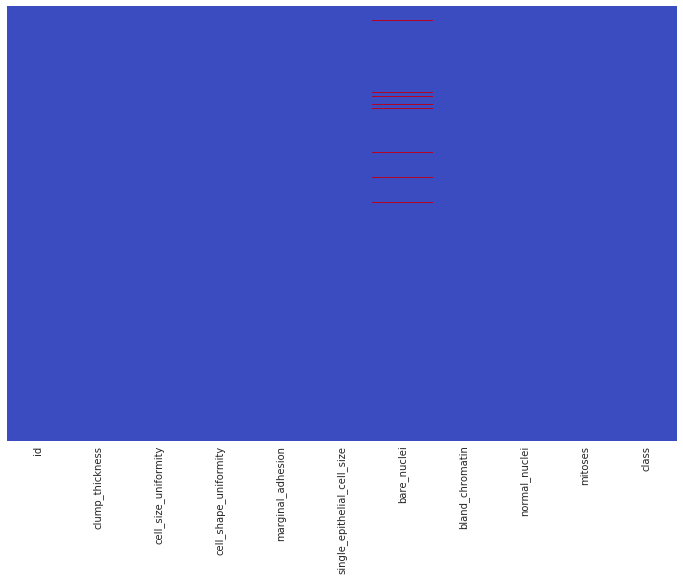

In [6]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(bcwDF == '?', cmap='coolwarm', yticklabels=False,cbar=False,ax=ax)

In [7]:
nans = bcwDF[bcwDF['bare_nuclei'] == '?']
nans.head()

,id,clump_thickness,cell_size_uniformity,cell_shape_uniformity,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nuclei,mitoses,class
23,1057013,8,4,5,1,2,?,7,3,1,4
40,1096800,6,6,6,9,6,?,7,8,1,2
139,1183246,1,1,1,1,1,?,2,1,1,2
145,1184840,1,1,3,1,2,?,2,1,1,2
158,1193683,1,1,2,1,3,?,1,1,1,2


In [8]:
print('Total number of samples with missing values:', len(nans))
print('Percentage of samples with missing values', round(len(nans)/len(bcwDF)*100,2),'%')

Total number of samples with missing values: 16
Percentage of samples with missing values 2.29 %


So there are 16 samples with missing values and this represents 2.3% of the total data. Let's see if we can fill this is any manner by viewing the distribution.

Text(0.5,1,'Bare Nuclei Count Plot')

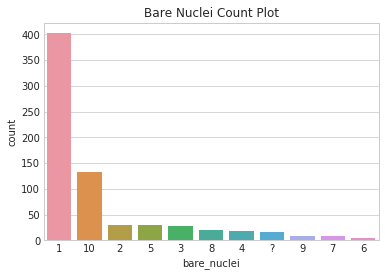

In [9]:
sns.countplot(x = 'bare_nuclei',
              data = bcwDF,
              order = bcwDF['bare_nuclei'].value_counts().index)
plt.title('Bare Nuclei Count Plot')

In [10]:
bcwDF['bare_nuclei'].value_counts().head()

1     402
10    132
2      30
5      30
3      28
Name: bare_nuclei, dtype: int64

In [11]:
bcwDF['bare_nuclei'].value_counts().head() / len(bcwDF)

1     0.575107
10    0.188841
2     0.042918
5     0.042918
3     0.040057
Name: bare_nuclei, dtype: float64

From the distribution, 57.5% of the samples of bare nuclei of 1. By assigning this value to the missing cells, the distribution should change that much.

In [12]:
bcwDF.set_value(bcwDF['bare_nuclei'] == '?', 'bare_nuclei', 1)

# Optionally, drop nans instead
#bcwDF = bcwDF[bcwDF['bare_nuclei'] != '?']

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.


,id,clump_thickness,cell_size_uniformity,cell_shape_uniformity,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nuclei,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
5,1017122,8,10,10,8,7,10,9,7,1,4
6,1018099,1,1,1,1,2,10,3,1,1,2
7,1018561,2,1,2,1,2,1,3,1,1,2
8,1033078,2,1,1,1,2,1,1,1,5,2
9,1033078,4,2,1,1,2,1,2,1,1,2


In [13]:
bcwDF['bare_nuclei'] = bcwDF['bare_nuclei'].astype(int)

This is how much the distribution changed:

In [14]:
bcwDF['bare_nuclei'].value_counts().head() / len(bcwDF)

1     0.597997
10    0.188841
5     0.042918
2     0.042918
3     0.040057
Name: bare_nuclei, dtype: float64

### Drop unneccessary feature
Here the id column will be dropped as it likely won't provide meaningful information in predicting the target.

In [15]:
bcwDF = bcwDF.drop('id',axis=1)

Each variable has over roughly 10 types so I will assume they are linearly releated.

### Convert class to binary

In [16]:
bcwDF['class'] = bcwDF['class'].apply(lambda x: 1 if x == 4 else 0)

### Class distribution check

Text(0.5,1,'Class Distribution')

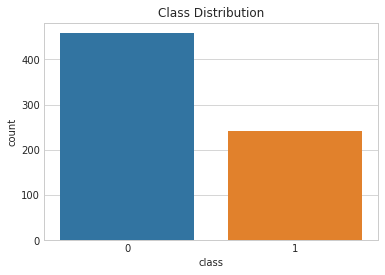

In [17]:
sns.countplot(x='class',data=bcwDF)
plt.title('Class Distribution')

In [18]:
bcwDF['class'].value_counts() / len(bcwDF)

0    0.655222
1    0.344778
Name: class, dtype: float64

### Balance Classes

In [19]:
samples_needed = bcwDF['class'].value_counts()[1]
samples_not_1 = bcwDF[(bcwDF['class'] == 0) & (bcwDF['bare_nuclei'] != 1)].shape[0]
samples_from_1 = samples_needed - samples_not_1

In [20]:
bal_bcwDF = pd.concat([bcwDF[bcwDF['class'] == 1],
                       bcwDF[(bcwDF['class'] == 0) & (bcwDF['bare_nuclei'] != 1)],
                       bcwDF[(bcwDF['class'] == 0) & (bcwDF['bare_nuclei'] == 1)].\
                           sample(n=samples_from_1)],
                      axis=0).sample(frac=1).reset_index(drop=True)

In [21]:
bal_bcwDF['class'].value_counts()

1    241
0    241
Name: class, dtype: int64

### Categorical / numerical feature check
Lastly, check if any of the columns are binary:

In [22]:
for col in bcwDF.columns.values:
    print(col, bcwDF[col].nunique())

clump_thickness 10
cell_size_uniformity 10
cell_shape_uniformity 10
marginal_adhesion 10
single_epithelial_cell_size 10
bare_nuclei 10
bland_chromatin 10
normal_nuclei 10
mitoses 9
class 2


Sanity check:

In [23]:
bcwDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
clump_thickness                699 non-null int64
cell_size_uniformity           699 non-null int64
cell_shape_uniformity          699 non-null int64
marginal_adhesion              699 non-null int64
single_epithelial_cell_size    699 non-null int64
bare_nuclei                    699 non-null int64
bland_chromatin                699 non-null int64
normal_nuclei                  699 non-null int64
mitoses                        699 non-null int64
class                          699 non-null int64
dtypes: int64(10)
memory usage: 54.7 KB


Save the processed dataframe.

In [24]:
#bcwDF.to_csv('data/processed/bcw.csv',index=False)
#bal_bcwDF.to_csv('data/processed/bal_bcw.csv',index=False)

## Data Exploration

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


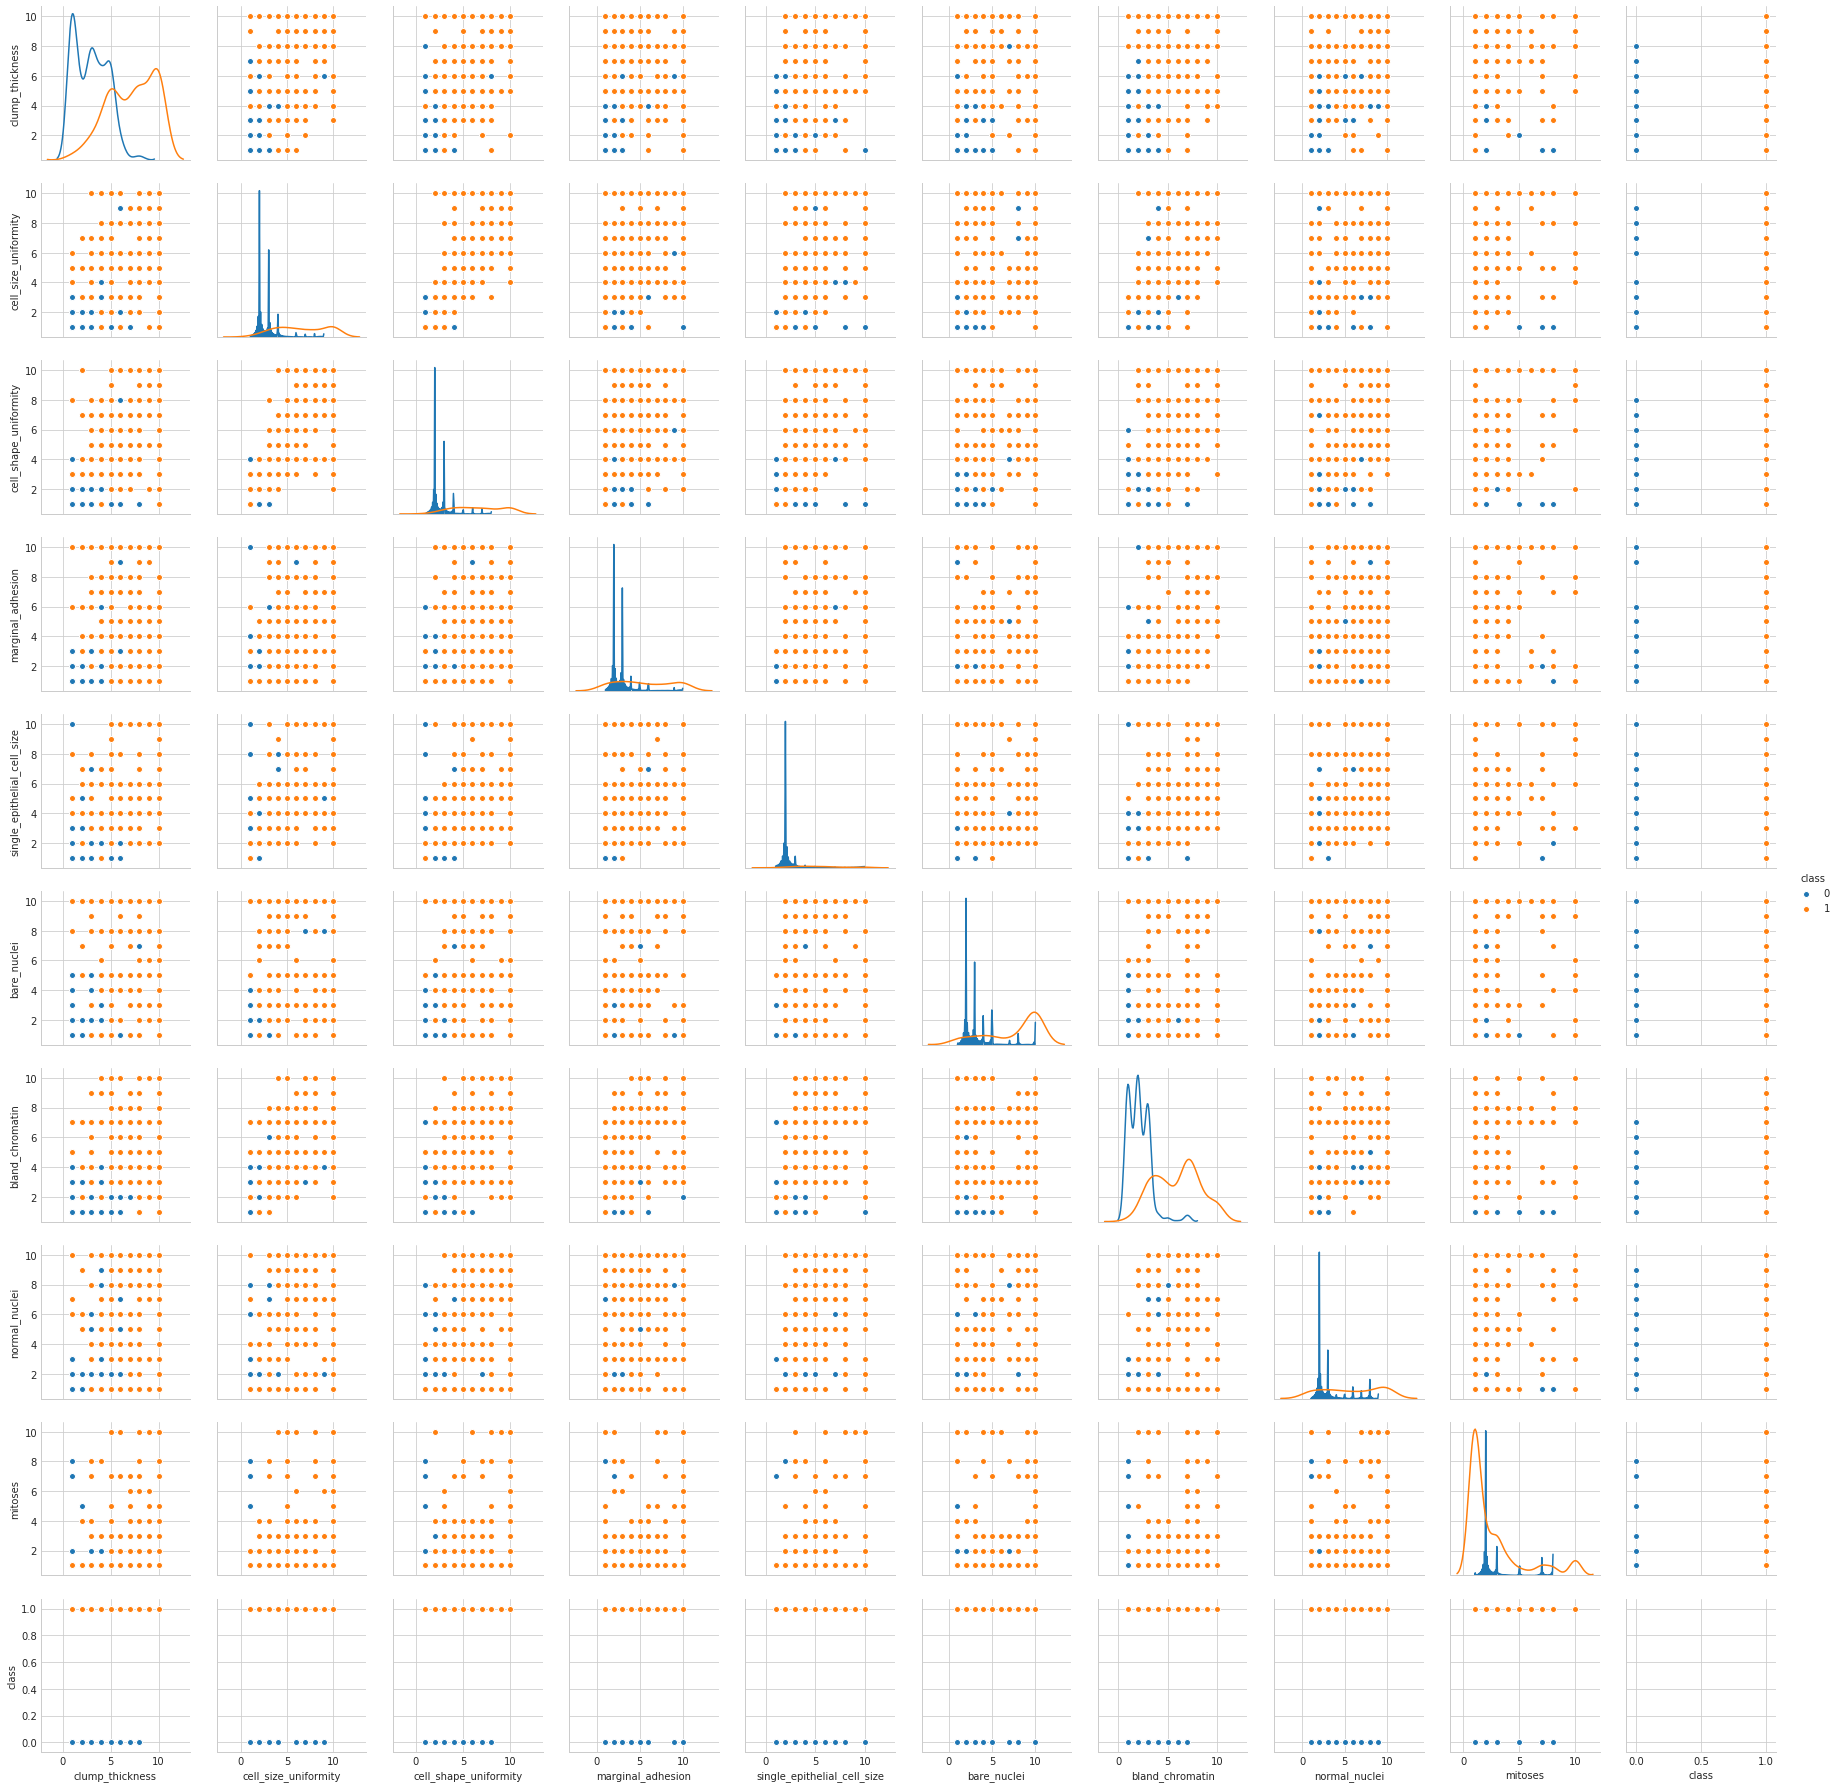

In [25]:
sns.pairplot(bcwDF, hue='class',diag_kind='kde')

In [26]:
bcwDF.head()

,clump_thickness,cell_size_uniformity,cell_shape_uniformity,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nuclei,mitoses,class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0


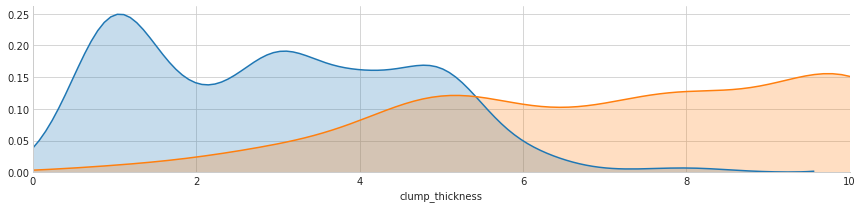

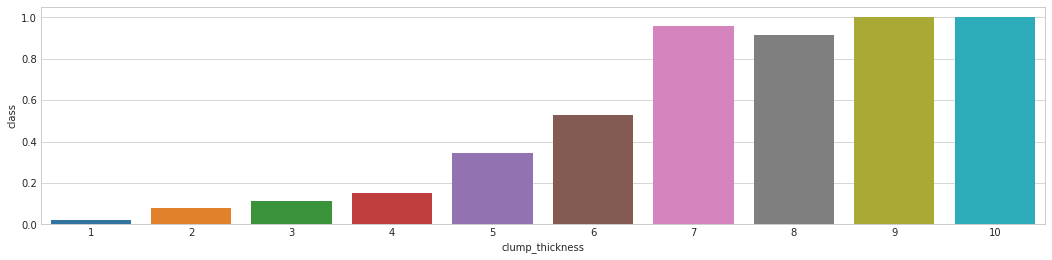

In [27]:
facet = sns.FacetGrid(bcwDF, hue='class', aspect=4)
facet.map(sns.kdeplot, 'clump_thickness', shade=True)
facet.set(xlim=(0, bcwDF['clump_thickness'].max()))

fig, ax = plt.subplots(1,1,figsize=(18,4))
ct_mean = bcwDF[['clump_thickness','class']].groupby(['clump_thickness'],as_index=False).mean()

sns.barplot(x='clump_thickness', y='class', data=ct_mean)

There is fairly clear separation between the classes with lower clump thickness likely indicating a negative prognosis.

## Machine Learning
Grab the features and the target. Can use either balanced or unbalanced.

In [28]:
X = bcwDF.drop(['class'],axis=1).astype(float)
y = bcwDF['class']

### Load results dataframe
Now the results dataframe is loaded if its exists, otherwise it is created.

In [29]:
try:
    resultsDF = pd.read_csv('results.csv')
    df_idx = len(resultsDF)
except IOError as e:
    resultsDF = pd.DataFrame(columns=['model','hyperparams','train_acc','train_std','test_acc','test_std'])
    df_idx = 0

In [30]:
resultsDF.head()

,model,hyperparams,train_acc,train_std,test_acc,test_std
0,nn,"{'alpha': 0.001, 'hidden_layer_sizes': (10, 20...",97.950187,0.327035,97.514919,2.530498
1,nn,"{'alpha': 0.1, 'hidden_layer_sizes': (20, 10)}",97.567997,0.301685,97.285714,2.161821
2,nn,"{'alpha': 0.0001, 'hidden_layer_sizes': (20, 10)}",97.738672,0.381516,97.218670,2.311759
3,nn,"{'alpha': 0.0001, 'hidden_layer_sizes': (10, 2...",98.015174,0.553384,97.218670,1.907621
4,nn,"{'alpha': 0.1, 'hidden_layer_sizes': (16, 32, ...",97.950160,0.386607,97.214408,2.582221


### Declare models to grid search

In [31]:
nb = GaussianNB()
svc = SVC(C=100, probability=True, gamma='auto')
knn = KNeighborsClassifier(n_neighbors=3)
lr = LogisticRegression(C=100, solver='lbfgs')#, random_state=seed)
nn = MLPClassifier((80, 10), early_stopping=False)#, random_state=seed)
gb = GradientBoostingClassifier(n_estimators=100)#, random_state=seed)
rf = RandomForestClassifier(n_estimators=10, max_features=3)#, random_state=seed)
dt = DecisionTreeClassifier()
ab = AdaBoostClassifier()
xgb = XGBClassifier()

models = {'svm': svc,
          'knn': knn,
          'gnb': nb,
          'nn': nn,
          'rf': rf,
          'gb': gb,
          'log': lr,
          'ab': ab,
          'dt': dt,
          'xgb': xgb
        }

### Cross Validation Utility Function
This function performs kFold cross validation with the given model and hyperparameters and the given dataset.

In [32]:
def crossValidate(typ, model, X, y, hyperparams='default', verbose=0):
    global df_idx
    
    # Update model hyperparameters if given
    if hyperparams is not 'default':
        model.set_params(**hyperparams)
    
    # Initialize scaler class
    scaler = StandardScaler()
    
    # Get kFolds
    kfold = KFold(n_splits=10)
    kfold.get_n_splits(X)

    # Initialize storage vectors
    trainACC = np.zeros(10)
    testACC = np.zeros(10)
    recall = np.zeros(10)
    precision = np.zeros(10)    
    np_idx = 0

    # Loop through folds
    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X.values[train_idx], X.values[test_idx]
        y_train, y_test = y.values[train_idx], y.values[test_idx]

        # Scale data
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Fit to training set
        model.fit(X_train, y_train)

        # Make predictions on testing set
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Compute training and testing accuracy
        trainACC[np_idx] = accuracy_score(y_train, y_train_pred)*100
        testACC[np_idx] = accuracy_score(y_test, y_test_pred)*100
        recall[np_idx] = recall_score(y_test,y_test_pred)*100
        precision[np_idx] = precision_score(y_test,y_test_pred)*100
        np_idx += 1
        
        # Print fold accuracy if verbose level 2
        if verbose == 2:
            print ("    Fold {}: Accuracy: {}%, Precision: {}%, Recall: {}%".format(np_idx, 
                                                                                   round(testACC[np_idx-1],3),
                                                                                   round(recall[np_idx-1],3),
                                                                                   round(precision[np_idx-1],3)))

    # Print average accuracy if verbose level 1
    if verbose == 1:
        print ("  Average Score: {}%({}%), Precision: {}%({}%), Recall: {}%({}%)".format(round(np.mean(testACC),3),round(np.std(testACC),3),
                                                                                        round(np.mean(precision),3),round(np.std(precision),3),
                                                                                        round(np.mean(recall),3),round(np.std(recall),3)))                             
    # Update dataframe
    resultsDF.loc[df_idx, 'model'] = typ
    resultsDF.loc[df_idx, 'hyperparams'] = str(hyperparams)
    resultsDF.loc[df_idx, 'train_acc'] = trainACC.mean()
    resultsDF.loc[df_idx, 'train_std'] = trainACC.std()
    resultsDF.loc[df_idx, 'test_acc'] = testACC.mean()
    resultsDF.loc[df_idx, 'test_std'] = testACC.std()
    resultsDF.loc[df_idx, 'test_recall_mean'] = recall.mean()
    resultsDF.loc[df_idx, 'test_recall_std'] = recall.std()
    resultsDF.loc[df_idx, 'test_precision_mean'] = precision.mean()
    resultsDF.loc[df_idx, 'test_precision_recall'] = precision.std()
    df_idx += 1                                         
                                         
    # Return average testing accuracy, and fitted model
    return testACC.mean(), model

### Generate base models
Now we will generate base models if the dataframe is brand new.
The base models are models with default hyperparameters. These set the baseline to beat for grid search below.

In [33]:
if len(resultsDF) == 0:
    for name, m in models.items():
        print ("Fitting " + name + " model")
        _, models[name] = crossValidate(name, m, X, y, 'default', 1)

### Results View
This shows the current best model performance for each model

In [34]:
resultsDF = resultsDF.sort_values('test_acc',ascending=False).reset_index(drop=True)
resultsDF.groupby('model').first().sort_values('test_acc',ascending=False)

,hyperparams,train_acc,train_std,test_acc,test_std
model,,,,,
nn,"{'alpha': 0.001, 'hidden_layer_sizes': (10, 20...",97.950187,0.327035,97.514919,2.530498
log,"{'solver': 'liblinear', 'C': 0.01}",96.995735,0.279154,96.997930,2.509911
rf,"{'n_estimators': 1300, 'bootstrap': True, 'min...",97.599768,0.240347,96.997930,3.026020
knn,{'n_neighbors': 8},97.234448,0.341133,96.786019,3.787626
gb,{'n_estimators': 600},100.000000,0.000000,96.714286,3.383634
gnb,{},96.258388,0.348456,96.342711,2.377779
ab,"{'n_estimators': 100, 'learning_rate': 0.1}",97.043480,0.356077,96.142857,4.519798
dt,"{'criterion': 'entropy', 'min_samples_split': ...",96.820804,0.795095,95.714286,2.996597
svm,"{'degree': 6, 'C': 10.0, 'gamma': 1}",100.000000,0.000000,95.424431,2.840350


### ROC Curve Plotting Utility Function
This function plots the ROC curve and returns the tpr/fpr.

In [35]:
def plot_roc_curve(name, model, X, y):
    # Initialize scaler
    scaler = StandardScaler()
    
    # Get kfolds
    kfold = KFold(n_splits=10)
    kfold.get_n_splits(X)

    # Initalize storage lists
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    i = 0
    # Loop through folds
    for train_idx, test_idx in kfold.split(X):
        # Split data
        X_train, X_test = X.values[train_idx], X.values[test_idx]
        y_train, y_test = y.values[train_idx], y.values[test_idx]

        # Scale data
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Fit model to fold
        model.fit(X_train, y_train)
        
        # Get probabilities for X_test
        y_test_proba = model.predict_proba(X_test)
        
        # Get FPR, TPR, and AUC vals based on probabilities
        fpr, tpr, _ = roc_curve(y_test, y_test_proba[:,1])
        roc_auc = auc(fpr, tpr)
        
        # Append tpr and auc
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(roc_auc)
     
        # Plot roc for fold
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
        i += 1
    
    # Plot random guessing line
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
    
    # Get mean tpr and mean/std for auc
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    # Plot mean curve
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Fill area between plots
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # style
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name + ' Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    
    return mean_fpr, mean_tpr, mean_auc, std_auc

### Draw ROC curves
Now the ROC curves for the current best models will be drawn.

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn

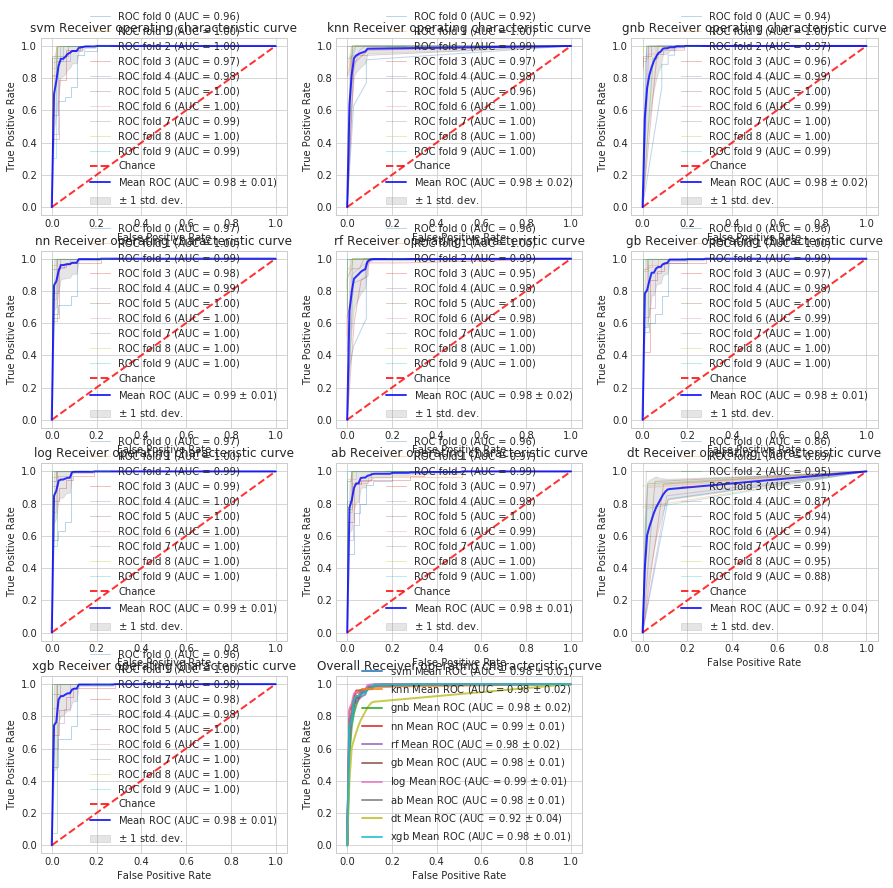

In [36]:
plt_id = 1
plt.figure(figsize=(15,15))
for name, m in models.items():
    ax = plt.subplot(4,3,plt_id)

    fpr, tpr, auc_mean, auc_std = plot_roc_curve(name, m, X, y)
    plt_id+=1
    
    ax = plt.subplot(4,3,11)
    plt.plot(fpr, tpr, label=name + r' Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (auc_mean, auc_std),
             lw=2, alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overall Receiver operating characteristic curve')
plt.legend(loc="lower right")

### Randomized Grid Search Utility Function
This function performs randomized grid search for a given model and set of hyperparameter optioons for num_trials

In [37]:
def gridSearch(name, models, param_grids, X, y, num_trials=100, verbose=0):
    # Get model and param grid
    model = models[name]
    current_param_grid = param_grids[name]
    
    # Create variable to store best model
    best_model = model    
    
    # Loop through trials
    for nTrial in range(num_trials):
        if verbose == 2 and nTrial % 10 == 0:
            print ('  Trial: %d' % (nTrial))
            
        # Get current best accuracy for model from the results dataframe
        best_acc = resultsDF[resultsDF['model'] == name]['test_acc'].max()
        
        # Randomly select params from grid
        params = {}
        for k, v in current_param_grid.items():
            params[k] = np.random.choice(v)
        
        # Cross validate model with selected hyperparams using the function we generated earlier
        acc,model = crossValidate(name, model, X, y, params, 0)
                
        # Update best model if it satisfies our optimizing metric
        if acc > best_acc:
            if verbose == 1:
                print ('    New best ' +  name + ' model: ' + str(acc))
            best_model = model
    # Return best model
    return best_model

### Param Grids
The param grids for the various models will be defined here:

In [38]:
param_grids = {}
param_grids['knn'] = {"n_neighbors": np.arange(1,11,1)}
param_grids['log'] = {'C': [0.001,0.01,0.1,1],
                      'solver':['newton-cg','lbfgs','liblinear','sag']}
param_grids['svm'] = {'C': [0.001,0.001,0.1,1,10,100], 'gamma':[1,2,3,4,5,6,7],
                              'degree': [3,4,5,6]}
param_grids['dt'] = {'criterion': ['gini','entropy'],
                     'max_depth': np.arange(1,6,1),
                     'min_samples_split': np.arange(3,10,1),
                     'max_features': np.arange(1,6,1)
                     }
param_grids['rf'] =  {'n_estimators': [int(x) for x in np.arange(10,2000,10)],
                      'max_features': ['auto','sqrt','log2'],
                      'max_depth': [int(x) for x in np.arange(1,7)] + [None],
                      'min_samples_split': [2,5,10],
                      'min_samples_leaf': [1,2,4],
                      'bootstrap': [True,False]
                      }
param_grids['ab'] = {'n_estimators': [50,100,150,300,500,1000],
                    'learning_rate': [0.001,0.01,0.1,1,2]}
param_grids['gnb'] = {}
param_grids['gb'] = {'n_estimators': [int(x) for x in np.arange(10,2000,10)]}
param_grids['nn'] = {'alpha': [1e-4,1e-3,1e-2,1e-1], 'hidden_layer_sizes': [(20,10),(80,10),(10,20,20,10),(20,20,20,20),(32,32,32),(64,64,64),(10,10,10),(64,64,64),(64,64,64,64),(16,32,64,64,32,16),(32,32,32,32,32,32)]}
param_grids['xgb'] = {'max_depth':[3,4,5], 
                      'learning_rate':[0.001,0.01,0.1],
                      'n_estimators': [50,100,150,300,500,1000],
                      'booster': ['gbtree','gblinear','dart'],
                     }

### Perform grid search
Each of the models will be grid searched within their space.

In [39]:
for name in models.keys():
    print (name)
    models[name] = gridSearch(name, models, param_grids, X, y, 5, 1)

svm


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/s

knn
gnb
nn


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

rf
gb
log
ab
dt
xgb


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is a

    New best xgb model: 94.85714285714286


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is a

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is a

In [40]:
# Save updated results to file
resultsDF.to_csv('results.csv',index=False)

### Results
Here we will see the results of hyperparameter tuning:

In [41]:
resultsDF = resultsDF.sort_values('test_acc',ascending=False).reset_index(drop=True)
resultsDF.groupby('model').first().sort_values('test_acc',ascending=False)

,hyperparams,train_acc,train_std,test_acc,test_std,test_recall_mean,test_recall_std,test_precision_mean,test_precision_recall
model,,,,,,,,,
nn,"{'alpha': 0.001, 'hidden_layer_sizes': (10, 20...",97.950187,0.327035,97.514919,2.530498,96.982397,2.242199,93.458546,4.084723
log,"{'solver': 'liblinear', 'C': 0.01}",96.995735,0.279154,96.997930,2.509911,96.318141,3.571722,95.994797,3.552107
rf,"{'n_estimators': 1890, 'bootstrap': True, 'min...",97.838191,0.176912,96.997930,3.026020,97.509329,3.634248,94.837441,3.854077
knn,{'n_neighbors': 8},97.234448,0.341133,96.786019,3.787626,94.889569,6.715262,96.719855,3.674166
gb,{'n_estimators': 600},100.000000,0.000000,96.714286,3.383634,96.125255,4.032690,95.974151,3.593672
gnb,{},96.258388,0.348456,96.342711,2.377779,97.777256,2.738804,91.141755,4.633619
ab,"{'n_estimators': 100, 'learning_rate': 0.1}",97.043480,0.356077,96.142857,4.519798,95.823182,6.507514,94.578042,4.090988
dt,"{'criterion': 'entropy', 'min_samples_split': ...",96.820804,0.795095,95.714286,2.996597,91.491130,8.508016,95.270591,4.371230
svm,"{'degree': 4, 'C': 10.0, 'gamma': 1}",100.000000,0.000000,95.424431,2.840350,98.951128,1.705495,87.385858,5.100957


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn

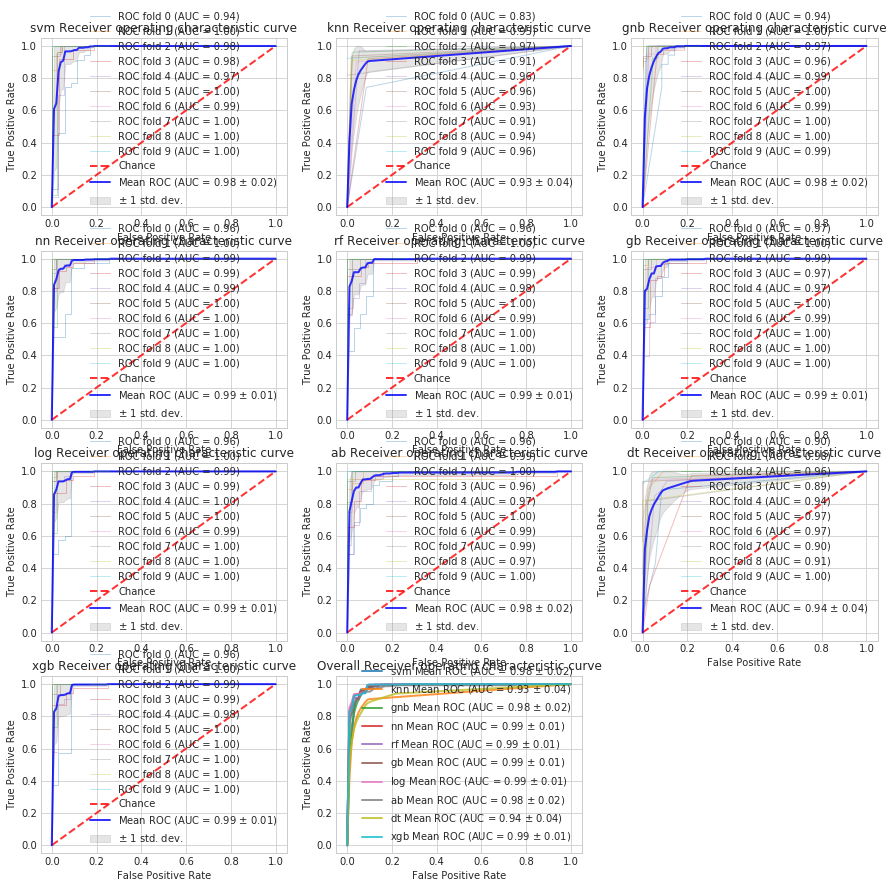

In [42]:
plt_id = 1
plt.figure(figsize=(15,15))
for name, m in models.items():
    ax = plt.subplot(4,3,plt_id)
    fpr, tpr, auc_mean, auc_std = plot_roc_curve(name, m, X, y)
    plt_id+=1
    
    ax = plt.subplot(4,3,11)
    plt.plot(fpr, tpr, label=name + r' Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (auc_mean, auc_std),
             lw=2, alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overall Receiver operating characteristic curve')
plt.legend(loc="lower right")